# Feature Selection and Dimensionality Reduction
     Reducing Complexity While Preserving Signal

## Objective

This notebook provides a systematic treatment of **feature selection and dimensionality reduction**, covering:

- Why fewer features often lead to better models
- Filter, wrapper, and embedded selection methods
- Multicollinearity and redundancy
- Linear vs nonlinear dimensionality reduction
- Feature selection inside pipelines

It answers:

    How do we reduce feature space without discarding predictive or business-relevant information?
    

## Why Feature Selection Matters

High-dimensional feature spaces can:

- Increase overfitting
- Inflate variance
- Slow training and inference
- Obscure interpretability
- Increase data leakage risk

More features ≠ more information.


## Imports and Dataset


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../datasets/03_feature_engineering/customer_feature_encoding_benchmark.csv")
df.head()

,customer_id,age,income,avg_monthly_usage,support_tickets,satisfaction_level,region,customer_segment,churn
0,0,69,32133.0,81.606182,0,Low,North,segment_20,0
1,1,32,17875.0,28.316858,1,Medium,East,segment_12,0
2,2,78,26139.0,41.475782,1,High,East,segment_11,0
3,3,38,54872.0,82.361651,1,Low,East,segment_9,0
4,4,41,48679.0,57.360148,0,Very High,South,segment_10,0


In [3]:
# Data structures
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              4614 non-null   float64
 3   avg_monthly_usage   4754 non-null   float64
 4   support_tickets     5000 non-null   int64  
 5   satisfaction_level  5000 non-null   object 
 6   region              5000 non-null   object 
 7   customer_segment    5000 non-null   object 
 8   churn               5000 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 351.7+ KB


In [4]:
# Remove missing Values
df = df.dropna(axis=0)

In [5]:
df['satisfaction_level'].unique()

array(['Low', 'Medium', 'High', 'Very High', 'Very Low'], dtype=object)

In [6]:
df['satisfaction_level'] = df['satisfaction_level'].map({'Low': 1, 
                              'Medium': 2, 
                              'High': 3, 
                              'Very High': 4, 
                              'Very Low': 5})

In [7]:
reg_dummy = pd.get_dummies(df['region'], drop_first=True, prefix='region', dtype=int)
df[reg_dummy.columns] = reg_dummy

# Separate Features and Target


In [8]:
target = "churn"

X = df.drop(columns=[target, "customer_id"])
y = df[target]


# – Redundancy and Correlation Analysis

Highly correlated features provide overlapping information.

## Correlation Matrix

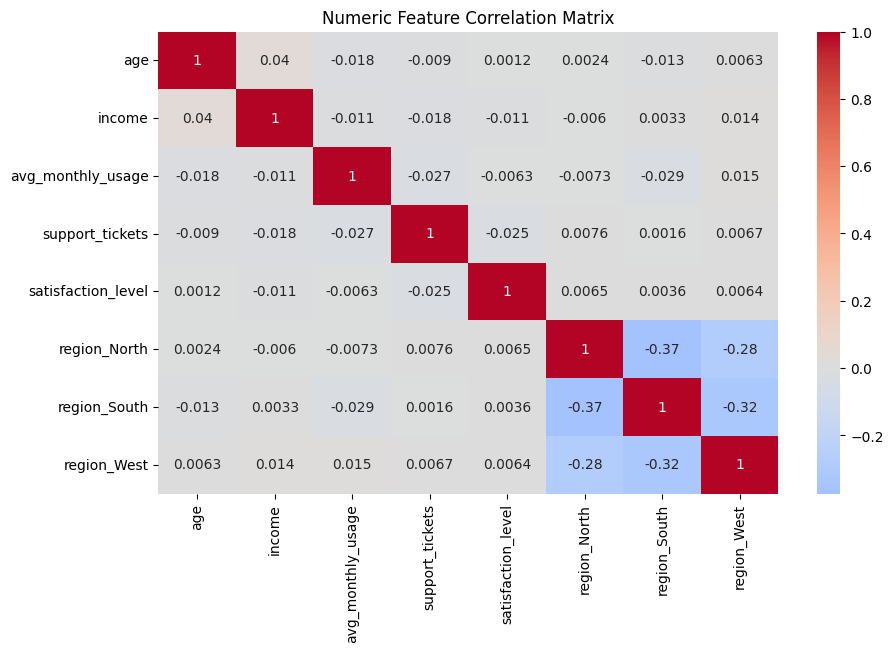

In [9]:
corr = X.select_dtypes(include=np.number).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True)
plt.title("Numeric Feature Correlation Matrix")
plt.show()


In [10]:
corr_1 =corr[['age', 'income', 'avg_monthly_usage', 'support_tickets',
'satisfaction_level', 'region_South', 'region_West']].loc[['age', 'income', 'avg_monthly_usage', 'support_tickets',
'satisfaction_level', 'region_South', 'region_West'],:]

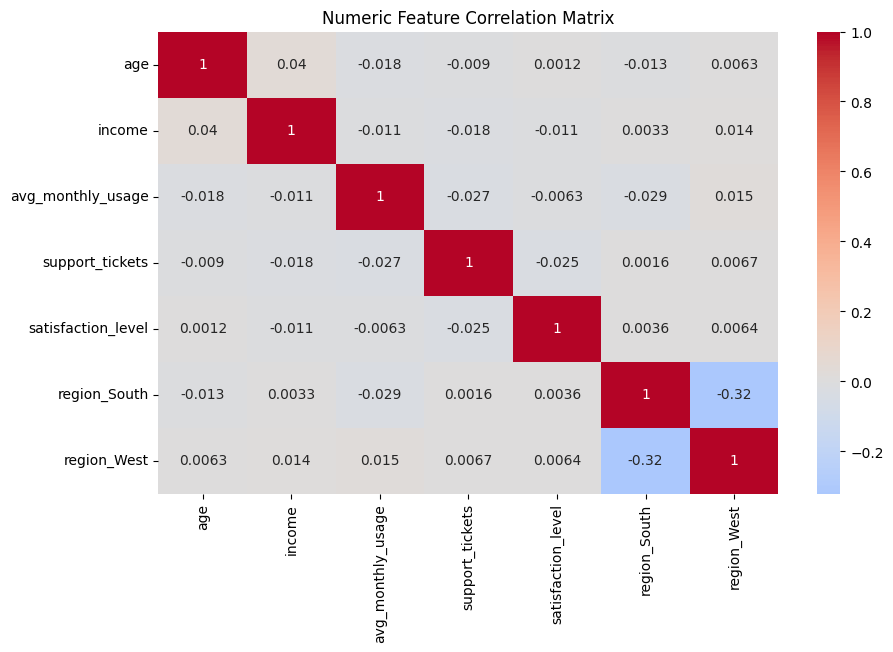

In [11]:
corr = X.select_dtypes(include=np.number).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_1, cmap="coolwarm", center=0, annot=True)
plt.title("Numeric Feature Correlation Matrix")
plt.show()


## Interpretation

- Strong correlations indicate redundancy
- Removing one feature may simplify models
- Business meaning should guide removal


# Variance Threshold (Filter Method)

Low-variance features often contribute little signal.


In [12]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X.select_dtypes(include=np.number))

X_var.shape


(4387, 8)

# Univariate Statistical Tests

Tests each feature independently against the target.


Mutual Information

In [13]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(
    X.select_dtypes(include=np.number),
    y,
    random_state=2010
)

mi = pd.Series(mi_scores, index=X.select_dtypes(include=np.number).columns)
mi.sort_values(ascending=False)


avg_monthly_usage     0.012164
support_tickets       0.009645
region_South          0.003065
age                   0.000172
income                0.000000
satisfaction_level    0.000000
region_North          0.000000
region_West           0.000000
dtype: float64

# Embedded Methods (Model-Based)

Tree-based models naturally rank feature importance.
## Random Forest Importance

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

rf.fit(X.select_dtypes(include=np.number), y)

importances = pd.Series(
    rf.feature_importances_,
    index=X.select_dtypes(include=np.number).columns
).sort_values(ascending=False)

importances


avg_monthly_usage     0.298542
income                0.293639
age                   0.230542
support_tickets       0.070076
satisfaction_level    0.066269
region_North          0.014989
region_West           0.013411
region_South          0.012533
dtype: float64

# Wrapper Methods (RFE)

Evaluates feature subsets by training models repeatedly.

## RFE (Recursive Feature Elimination)

# Filter vs Wrapper vs Embedded

| Method | Pros | Cons |
|------|------|------|
| Filter | Fast, simple | Ignores interactions |
| Wrapper | Accurate | Expensive |
| Embedded | Balanced | Model-dependent |


# Dimensionality Reduction (PCA)

Transforms features into orthogonal components.


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_num = X.select_dtypes(include=np.number)

X_scaled = StandardScaler().fit_transform(X_num)

pca = PCA()
pca.fit(X_scaled)
pca.explained_variance_ratio_

array([0.17243074, 0.15972654, 0.13121689, 0.12912471, 0.12578791,
       0.11998657, 0.1184368 , 0.04328984])

## Explained Variance

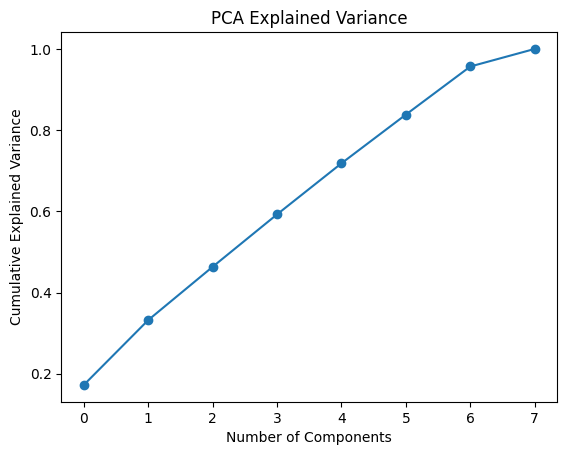

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o', )
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


### Interpretation

- PCA improves stability
- Reduces multicollinearity
- Sacrifices interpretability
- Best for distance-based models


#  Feature Selection Inside Pipelines
## Pipeline Example

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selector", SelectFromModel(
        RandomForestClassifier(n_estimators=200, random_state=42)
    )),
    ("model", LogisticRegression(max_iter=1000))
])


# Feature Reduction by Model Type


| Model | Selection Needed |
|------|----------------|
| Linear | Yes |
| Tree-Based | Optional |
| KNN / SVM | Strongly |
| Neural Networks | Often |


# Common Mistakes (Avoided)

- `[neg] -` Feature selection before split
- `[neg] -` Using target-aware filters improperly
- `[neg] -` Blind PCA usage
- `[neg] -` Removing business-critical features


# Summary Table

| Technique | Use Case |
|---------|----------|
| Correlation | Redundancy removal |
| MI | Nonlinear relevance |
| RFE | Small datasets |
| PCA | High-dimensional data |
| Embedded | Production pipelines |


# Key Takeaways

- Feature selection improves generalization
- Dimensionality reduction trades interpretability for stability
- Embedded methods are safest defaults
- Pipelines prevent leakage
- Business context overrides statistics


## Next Notebook

03_Feature_Engineering/

└── [06_feature_crosses_and_polynomials.ipynb](06_feature_crosses_and_polynomials.ipynb)


<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)